# 16.15 Procesamiento de Señales Biomédicas - 1C 2022

## Trabajo final
## Consigna a elegir - Tema 1: Clasificador de estados del sueño

Sophie Marcó Fari (legajo 59545) y Guadalupe Sosa Ferro (legajo 59042)

# Montamos Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install y librerías

In [1]:
! pip install wfdb
! pip install pyhrv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [2]:
! python -m pip uninstall matplotlib
# instalamos una versión de matplotlib que nos sirva para continuar graficando
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.9.0
Uninstalling matplotlib-3.9.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/matplotlib-3.9.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/matplotlib/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.10/dist-packages/pylab.py
Proceed (Y/n)? y
  Successfully uninstalled matplotlib-3.9.0
  Using cached matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 3.1.3 which is incompatible.
bigframes 1.9.0 requires matplotlib>=3.7.1, but you have matplotlib 3.1.3 which is incompatible.
mizani 0.9.3 requires matplotli

In [24]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
import wfdb
from wfdb import processing
import pyhrv
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Rutas a los archivos

En primer lugar se cargan las rutas a la carpeta que contiene los archivos que se utilizaran. La ruta solo contiene el nombre del archivo, sin su extensión, ya que las funciones que se utilizan para obtener las señales y datos asociados no lo necesitan.

In [6]:
registro1 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp01a"
registro2 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp01b"
registro3 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp02a"
registro4 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp02b"
registro5 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp03"
registro6 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp04"
registro7 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp14"
registro8 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp16"
registro9 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp32"
registro10 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp37"
registro11 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp41"
registro12 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp45"
registro13 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp48"
registro14 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp59"
registro15 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp60"
registro16 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp61"
registro17 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp66"
registro18 = "/content/drive/Shareddrives/PSB/Final/Ej2/Archivos/slp67x"


registros = [registro1, registro2, registro3, registro4, registro5, registro6, registro7, registro8, registro9, registro1, registro11, registro12, registro13, registro14, registro15, registro16, registro17, registro18]

fs = 250

# Función obtencionDatos

Con esta función se obtienen las señales, utilizando la funcion `rdsamp` de la librería `wfdb`. Esta recibe el nombre del archivo y devuelve un array con todas las señales (cuyo archivo tiene el nombre ingresado) y un diccionario con atributos de las señales. Del archivo slpdb.shtml sabemos que para todos los registros, la señal de ECG está en la posición 0 del array.

Por otro lado, también se obtienen las anotaciones sobre las etapas del sueño y apneas con la función `rdann`. Se obtienen por un lado los simbolos que determinan estas etapas y la presencia de apneas, y por otro los números de muestras correspondientes a estas.

In [7]:
def obtencionDatos(registro):

  # Señales de ECG
  senales, fields = wfdb.rdsamp(registro) # Señales y campos con información sobre estas
  ecg = senales[:, 0] # La señal de ECG está en la posición 0

  # Anotaciones
  anotaciones = wfdb.rdann(registro, 'st')
  simbolos_anotaciones = anotaciones.aux_note # Simbolos que identifican a las etapas de sueño y apneas
  muestras_anotaciones = anotaciones.sample.tolist() # Números de muestra
  muestras_anotaciones[0] = 0 # Como las anotaciones empiezan desde la muestra 1 pero queremos que todos los segmentos tengan la misma duración, hacemos que empiezen desde la muestra 0. (Graficamos las señales y los valores en esta posicion eran normales.)

  return ecg, simbolos_anotaciones, muestras_anotaciones

# Función segmentarECG

Como su nombre indica, esta función segmenta cada señal de ECG en base a los datos de las anotaciones. Se utilizan los números de muestra para definir cada segmento, que estrá caracterizado por una etapa del sueño y la presencia (o no) de apnea.

Según las anotaciones, en todas las señales los segmentos son de 7500 muestras, es decir 30 segundos.

In [8]:
def segmentarECG(ecg, muestras_anotaciones, fs):
  segmentos_ecg = []

  for i in range(1, len(muestras_anotaciones)):
    segmentos_ecg.append(ecg[muestras_anotaciones[i-1]:muestras_anotaciones[i]])
  segmentos_ecg.append(ecg[muestras_anotaciones[i]:])
  # Como tomo desde la muestra 0, tengo el mismo numero de muestras y de simbolos entonces no tengo que modificar la lista de anotacioens

  t_fin = len(segmentos_ecg[1])/fs
  tiempo = np.linspace(0, t_fin, len(segmentos_ecg[1]))

  return segmentos_ecg, tiempo

# Función eliminarApneas

Luego, como pide la consigna, eliminamos aquellos segmentos marcados con apnea y tiempo de movimiento corporal. De esta manera solo quedan los segmentos correspondientes al paciente despierto, en sueño no REM y en sueño REM. Debido a que pertenecen a la misma etapa, se agrupan las fases 1 a 4 en etapa no REM. Entonces, el clasificador que se obtiene más adelante, clasificará los segmentos en "Vigilia", "No REM", y "REM".

In [9]:
def eliminarApneas(segmentos_ecg, simbolos_anotacion):

  segmentos_ecg_sin_apneas = []
  simbolos_sin_apneas = []

  for i in range(len(segmentos_ecg)):
    if "H" not in simbolos_anotacion[i] and "HA" not in simbolos_anotacion[i] and "OA" not in simbolos_anotacion[i] and "X" not in simbolos_anotacion[i] and "CA" not in simbolos_anotacion[i] and "CAA" not in simbolos_anotacion[i] and "L" not in simbolos_anotacion[i] and "LA" not in simbolos_anotacion[i] and "A" not in simbolos_anotacion[i] and "MT" not in simbolos_anotacion[i] and "M" not in simbolos_anotacion[i]:
      segmentos_ecg_sin_apneas.append(segmentos_ecg[i])
      simbolos_sin_apneas.append(simbolos_anotacion[i])

  for j in range(0, len(simbolos_sin_apneas)):
    if ("W" in simbolos_sin_apneas[j]):
      simbolos_sin_apneas[j] = "Vigilia"
    elif ("1" in simbolos_sin_apneas[j] or "2" in simbolos_sin_apneas[j] or "3" in simbolos_sin_apneas[j] or "4" in simbolos_sin_apneas[j]):
      simbolos_sin_apneas[j] = "No REM"
    elif ("R" in simbolos_sin_apneas[j]):
      simbolos_sin_apneas[j] = "REM"

  return segmentos_ecg_sin_apneas, simbolos_sin_apneas

# Función detectorQRS

Se detectan los complejos QRS mediante una función parecida a la utilizada en el TP 2. En primer lugar, se pasa la señal por un filtro pasabanda entre 5 y 15 Hz, tomando el orden igual a 5. Luego se utilizó un filtro derivativo de orden 6 y dicha señal fue rectificada e integrada. Con la señal integrada se obtienen las muestras y los tiempos en los cuales se dan los picos de la señal integrada, es decir las ondas R. La función permite graficar las señales de la primera y última etapa y los picos.

In [10]:
def detectorQRS(segmentos_senal, duracionMinima, umbral, tiempo, fs, t_i = 0, t_f = 30, graficar = False):

  tiempoPicos_segmentos = []

  indicesPicos_segmentos = []

  senalIntegrada_segmentos = []

  for i in range(len(segmentos_senal)):

    senal = segmentos_senal[i]

    # Filtro pasabanda entre 5 y 15 Hz
    L1 = 5 # Orden
    wn = [5, 15] # Frecuencias de corte
    [bPasabanda, aPasabanda] = scipy.signal.butter(L1, Wn = wn, btype = 'bandpass', analog=False, output = 'ba', fs = fs)
    senalFiltradaPasabanda = scipy.signal.filtfilt(bPasabanda, aPasabanda, senal)

    # Filtro derivativo
    L2 = 6
    bDerivativo = [(0.1/(2*L2))*fs, 0, 0, 0, 0, -(0.1/(2*L2))*fs]
    senalFiltradaDerivativo = scipy.signal.filtfilt(bDerivativo, 1, senalFiltradaPasabanda)

    # Rectificación
    senalRectificada = (senalFiltradaDerivativo)**2

    # Integración
    bIntegracion = np.ones(int(0.15*fs))/int((0.15*fs))
    senalIntegrada = scipy.signal.filtfilt(bIntegracion, 1, senalRectificada)
    senalIntegrada_segmentos.append(senalIntegrada)

    # Detección complejos QRS
    duracionMin = (duracionMinima)*fs
    umbralMin = umbral*np.max(senalIntegrada)
    indicesPicos = scipy.signal.find_peaks(senalIntegrada, distance = duracionMin)[0]
    indicesPicos_segmentos.append(indicesPicos)
    tiempoPicos = indicesPicos/fs
    tiempoPicos_segmentos.append(tiempoPicos)

    # Gráficos
    if graficar == True:

      inicio = t_i*fs
      final = fs*t_f

      fig, axs = plt.subplots(2, figsize=(15,10))

      axs[0].plot(tiempo[inicio:final], senalFiltradaPasabanda[inicio:final])
      axs[0].plot(tiempoPicos, senalFiltradaPasabanda[indicesPicos], 'x', color='r', label = 'Pico máximo del complejo QRS')
      axs[0].grid()
      axs[0].legend()
      axs[0].set_xlim([t_i, t_f])
      axs[0].set_title(f"Señal con filtro pasabanda (registro {i})")

      axs[1].plot(tiempo[inicio:final], senalIntegrada[inicio:final])
      axs[1].plot(tiempoPicos, senalIntegrada[indicesPicos], 'x', color='r', label = 'Pico')
      axs[1].grid()
      axs[1].legend()
      axs[1].set_xlim([t_i, t_f])
      axs[1].set_ylim([0, 1.1*np.max(senalIntegrada[inicio:final])])
      axs[1].set_title(f"Señal integrada (registro {i})")
      axs[1].axhline(y = umbralMin, xmin = 0, xmax = 1, color = "green", linewidth = 1, linestyle = "--", label='umbral')

      axs[0].set(ylabel = "Amplitud")
      axs[1].set(xlabel = "Tiempo [s]")

      fig.suptitle(f"Etapas de filtrado de la señal de ECG para la detección de complejos QRS", fontsize = 18)
      fig.show()
      plt.tight_layout(pad = 7)

  return tiempoPicos_segmentos, indicesPicos_segmentos

# Función obtenerSerieRR

En base a las muestras y los tiempos donde se dan los picos del complejo QRS se desea obtener la serie RR. La misma es una serie que da cuenta de la frecuencia instantánea o período instantáneo que tiene el ritmo cardíaco. De acuerdo a esos intervalos se puede sacar bastante informacion clínica útil.

A su vez, esas series pueden ser abordadas desde distintos dominios o aproximaciones para obtener la información clínica útil, los mismos son: temporal, espectral y no lineal. Efectivamente más adelante se analiza la serie RR limpia en el dominio del tiempo y las frecuencias.

In [11]:
def obtenerSerieRR(indicesPicos_segmentos, tiempoPicos_segmentos, graficar = False):

  RR_segmentos = []

  RRt_segmentos = []

  RRf_segmentos = []

  for k in range(len(indicesPicos_segmentos)):

    indicesPicos = indicesPicos_segmentos[k]

    RR = [j-i for i,j in zip(indicesPicos[0:-2], indicesPicos[1:-1])]
    RR_segmentos.append(RR)

  for l in range(len(tiempoPicos_segmentos)):

    tiemposPicos = tiempoPicos_segmentos[l]
    RRt = [j-i for i,j in zip(tiemposPicos[0:-2], tiemposPicos[1:-1])]
    for r in range(len(RRt)):
      RRt[r] = round(RRt[r], 3)
    RRt_segmentos.append(RRt)

    RRf = 60/np.array(RRt)
    RRf_segmentos.append(RRf)

    if graficar == True:
      plt.figure(figsize=(30,5))
      plt.stem(RRt)
      plt.xlabel("Muestras")
      plt.ylabel("Intervalo [s]")
      plt.grid()
      plt.title(f"Serie RR del ECG (registro {l})")
      plt.show()

      plt.figure(figsize=(30,5))
      plt.stem(RRf)
      plt.xlabel("Muestras")
      plt.ylabel("Frecuencia cardiaca instantánea [latidos/min]")
      plt.grid()
      plt.title(f"Serie RR del ECG (registro {l})")
      plt.show()

  return RR_segmentos

# Funcion obetenerSerieNN

Para el análisis de las características temporales y espectrales nos interesan los intervalos RR asociados a los latidos que nacieron en el nodo sinusal. Los ectópicos, por su parte, nacen fuera del nodo sinusal (ventrículo). Como estos cambios no vienen dados por la modulacion autonomica del nodo sinusal, su actividad no van a ser de nuestro interés y van a actuar como interferencia. Con lo cual, una vez que se tiene construida la serie de intervalos RR, se utiliza esta función para eliminar los latidos ectópicos y obtener la serie NN. Se analiza cada intervalo de la serie RR teniendo en cuenta las condiciones especificadas en la consigna. Al momento de guardar los intervalos normales se pasan a tiempo. De esta manera la serie NN temporal ya está lista para ser analizada.

In [12]:
def obetenerSerieNN(RR_segmentos, fs, indicesPicos_segmentos, graficar = False):

  NNt_segmentos = []
  indicesPicosNormales_segmentos = []

  for j in range(len(RR_segmentos)):
    RR = RR_segmentos[j]
    NNt = []
    indicesPicos = indicesPicos_segmentos[j]
    indicesPicosNormales = []
    media = np.mean(RR)
    ds = np.std(RR)

    for i in range(len(RR)):
      if RR[i]>0.7*media and RR[i]<1.3*media and RR[i]<(media+3*ds) and RR[i]>(media-3*ds):
        NNt.append(round(RR[i]/fs, 3)) # Guardo solo los intervalos RR que cumplen con las condiciones
        indicesPicosNormales.append(indicesPicos[i])
    indicesPicosNormales.append(indicesPicos[i+1])
    indicesPicosNormales.append(indicesPicos[i+2])

    NNt = scipy.signal.resample(NNt, 5*30)
    NNt_segmentos.append(NNt) # Intervalos NN en tiempo
    indicesPicosNormales_segmentos.append(indicesPicosNormales)

    if graficar == True:
      plt.figure(figsize=(30,5))
      plt.stem(NNt)
      plt.xlabel("Muestras")
      plt.ylabel("Intervalo [s]")
      plt.grid()
      plt.title(f"Serie NN del ECG (registro {j})")
      plt.show()

  return NNt_segmentos, indicesPicosNormales_segmentos

# Función caracteristicasTemporales

*Dominio temporal*

Sobre la serie de intervalos RR, primero habiendo corregido la serie de la presencia de ectópicos, se tiene una serie de intervalos NN y luego se aplican métodos estadísticos para determinar cuánto varia esa serie.

In [13]:
def caracteristicasTemporales(NNt_segmentos):

  media_segmentos = []
  SD_segmentos = []
  RMSSD_segmentos = []

  for i in range(len(NNt_segmentos)):
    NNt = NNt_segmentos[i]

    media = np.mean(NNt)
    media_segmentos.append(media)

    SD = np.std(NNt)
    SD_segmentos.append(SD)

    RMSSD = []
    for j in range(len(NNt)-1):
      dif = (NNt[j+1] - NNt[j]) ** 2
      RMSSD.append(dif)
    prom = np.mean(RMSSD)
    raiz = np.sqrt(prom)
    RMSSD_segmentos.append(raiz)

  return media_segmentos, SD_segmentos, RMSSD_segmentos

# Función caracteristicasEspectrales

*Análisis espectral*

Realizamos este análisis, ya que estamos trabajando con ventanas de tiempo cortas. Obtenemos entonces la densidad espectral de potencia con FFT, con AR y con Lomb. De acuerdo a en qué frecuencia haya mayor potencia, se va a ver una predominancia del sistema simpático o parasimpático.

Hay 3 bandas muy diferenciadas: muy baja frecuencia, baja frecuencia y alta frecuencia de acuerdo a dónde están los picos, cada banda está asociada a una rama del sistema autónomo.

In [14]:
def caracteristicasEspectrales(NNt_segmentos, indicesPicosNormales_segmentos, fs):

  LFn_fft_segmentos = []
  HFn_fft_segmentos = []
  ratio_fft_segmentos = []
  LFn_ar_segmentos = []
  HFn_ar_segmentos = []
  ratio_ar_segmentos = []
  LFn_lomb_segmentos = []
  HFn_lomb_segmentos = []
  ratio_lomb_segmentos = []

  for i in range(len(NNt_segmentos)):

    NNt = np.array(NNt_segmentos[i])
    tiemposPicosNormales = np.multiply(indicesPicosNormales_segmentos[i], 1/fs)

    # Densidad espectral de potencia con FFT
    plt.ioff()
    psd_fft = pyhrv.frequency_domain.welch_psd(NNt, tiemposPicosNormales, show = False, show_param = False, legend = False)
    plt.close()
    VLF_fft = psd_fft['fft_abs'][0]
    LF_fft = psd_fft['fft_abs'][1]
    HF_fft = psd_fft['fft_abs'][2]

    LFn_fft = (LF_fft*100)/((LF_fft + HF_fft) - VLF_fft)
    LFn_fft_segmentos.append(LFn_fft)

    HFn_fft = (HF_fft*100)/((LF_fft + HF_fft) - VLF_fft)
    HFn_fft_segmentos.append(HFn_fft)

    ratio_fft = psd_fft['fft_ratio']
    ratio_fft_segmentos.append(ratio_fft)

    # Densidad espectral de potencia con AR
    plt.ioff()
    psd_ar = pyhrv.frequency_domain.ar_psd(NNt, tiemposPicosNormales, show = False, show_param = False, legend = False)
    plt.close()
    VLF_ar = psd_ar['ar_abs'][0]
    LF_ar = psd_ar['ar_abs'][1]
    HF_ar = psd_ar['ar_abs'][2]

    LFn_ar = (LF_ar*100)/((LF_ar + HF_ar)-VLF_ar)
    LFn_ar_segmentos.append(LFn_ar)

    HFn_ar = (HF_ar*100)/((LF_ar + HF_ar)-VLF_ar)
    HFn_ar_segmentos.append(HFn_ar)

    ratio_ar = psd_ar['ar_ratio']
    ratio_ar_segmentos.append(ratio_ar)

    # Densidad espectral de potencia con Lomb
    plt.ioff()
    psd_lomb = pyhrv.frequency_domain.lomb_psd(NNt, tiemposPicosNormales, show = False, show_param = False, legend = False)
    plt.close()
    VLF_lomb = psd_lomb['lomb_abs'][0]
    LF_lomb = psd_lomb['lomb_abs'][1]
    HF_lomb = psd_lomb['lomb_abs'][2]

    LFn_lomb = (LF_lomb*100)/((LF_lomb + HF_lomb) - VLF_lomb)
    LFn_lomb_segmentos.append(LFn_lomb)

    HFn_lomb = (HF_lomb*100)/((LF_lomb + HF_lomb) - VLF_lomb)
    HFn_lomb_segmentos.append(HFn_lomb)

    ratio_lomb = psd_lomb['lomb_ratio']
    ratio_lomb_segmentos.append(ratio_lomb)

  return LFn_fft_segmentos, HFn_fft_segmentos, ratio_fft_segmentos, LFn_ar_segmentos, HFn_ar_segmentos, ratio_ar_segmentos, LFn_lomb_segmentos, HFn_lomb_segmentos, ratio_lomb_segmentos

# Aplicación de las funciones a las señales

A continuación se aplican las funciones previamente definidas. A modo de resumen, para cada registro se realiza:

1.   Obtención de los datos de los archivos
2.   Segmentación de las señales de ECG
3.   Eliminación de segmentos de apneas y movimientos
4.   Detección de los complejos QRS
5.   Obtención de la serie RR
6.   Obtención de la serie NN
7.   Cálculo de las características temporales
8.   Cálculo de las características espectrales

Luego, se guardan en distintas listas las características calculadas para cada registro. Se utiliza la función `extend` para crear listas de 1D ya que ya no nos interesa diferenciar entre pacientes.

In [15]:
simbolos_registros = []

media_registros = []
SD_registros = []
RMSSD_registros = []

LFn_fft_registros = []
HFn_fft_registros = []
ratio_fft_registros = []
LFn_ar_registros = []
HFn_ar_registros = []
ratio_ar_registros = []
LFn_lomb_registros = []
HFn_lomb_registros = []
ratio_lomb_registros = []

duracionMinima = 0.5
umbral = 0.2

for n in range(len(registros)):

  registro = registros[n]

  # Procesamiento de las señales de ECG para obtener las características temporales y espectrales

  ecg, simbolos_anotaciones, muestras_anotaciones = obtencionDatos(registro)

  segmentos_ecg, tiempos = segmentarECG(ecg, muestras_anotaciones, fs)

  segmentos_ecg_sin_apneas, simbolos_sin_apneas = eliminarApneas(segmentos_ecg, simbolos_anotaciones)

  tiempoPicos_segmentos, indicesPicos_segmentos = detectorQRS(segmentos_ecg_sin_apneas, duracionMinima, umbral, tiempos, fs)

  RR_segmentos = obtenerSerieRR(indicesPicos_segmentos, tiempoPicos_segmentos)

  NNt_segmentos, indicesPicosNormales_segmentos = obetenerSerieNN(RR_segmentos, fs, indicesPicos_segmentos)

  media_segmentos, SD_segmentos, RMSSD_segmentos = caracteristicasTemporales(NNt_segmentos)

  LFn_fft_segmentos, HFn_fft_segmentos, ratio_fft_segmentos, LFn_ar_segmentos, HFn_ar_segmentos, ratio_ar_segmentos, LFn_lomb_segmentos, HFn_lomb_segmentos, ratio_lomb_segmentos = caracteristicasEspectrales(NNt_segmentos, indicesPicosNormales_segmentos, fs)

  # Se guarda en una lista las caracteristicas de cada registro

  simbolos_registros.extend(np.array(simbolos_sin_apneas))

  media_registros.extend(media_segmentos)

  SD_registros.extend(SD_segmentos)

  RMSSD_registros.extend(RMSSD_segmentos)

  LFn_fft_registros.extend(LFn_fft_segmentos)

  HFn_fft_registros.extend(HFn_fft_segmentos)

  ratio_fft_registros.extend(ratio_fft_segmentos)

  LFn_ar_registros.extend(LFn_ar_segmentos)

  HFn_ar_registros.extend(HFn_ar_segmentos)

  ratio_ar_registros.extend(ratio_ar_segmentos)

  LFn_lomb_registros.extend(LFn_lomb_segmentos)

  HFn_lomb_registros.extend(HFn_lomb_segmentos)

  ratio_lomb_registros.extend(ratio_lomb_segmentos)

Se crean luego tres nuevas listas. En cada una, se se guardan las características temporales y las características espectrales calculadas con un algoritmo (FFT, AR o Lomb). Esto es así ya que luego crearemos clasificadores de etapas de sueño en base a las características temporales y espectrales obtenidas con uno de los algoritmos.

In [16]:
caracteristicas_fft = [np.array(media_registros), np.array(SD_registros), np.array(RMSSD_registros), np.array(LFn_fft_registros), np.array(HFn_fft_registros), np.array(ratio_fft_registros)]

caracteristicas_ar = [np.array(media_registros), np.array(SD_registros), np.array(RMSSD_registros), np.array(LFn_ar_registros), np.array(HFn_ar_registros), np.array(ratio_ar_registros)]

caracteristicas_lomb = [np.array(media_registros), np.array(SD_registros), np.array(RMSSD_registros), np.array(LFn_lomb_registros), np.array(HFn_lomb_registros), np.array(ratio_lomb_registros)]

# Clasificador basado en machine learning

## Creación de DataFrames

Para la creación de los DataFrames que se utilizaran en los clasificadores, primero se crean los siguientes diccionarios.

In [17]:
def crearDataFrames(caracteristicas, simbolos):

  # Creación de diccionario
  diccionario = {}

  for i in range(0, len(caracteristicas[0])):
    diccionario[i] = {'media':caracteristicas[0][i],
                          'sd':caracteristicas[1][i],
                          'rmssd':caracteristicas[2][i],
                          'lfn':caracteristicas[3][i],
                          'hfn':caracteristicas[4][i],
                          'lf_hf':caracteristicas[5][i],
                          'etapa':simbolos[i]}

  # Creación de DataFrame
  df = pd.DataFrame([key for key in diccionario.keys()], columns = ['Segmento'])

  df['Media'] = [value['media'] for value in diccionario.values()]
  df['SD'] = [value['sd'] for value in diccionario.values()]
  df['RMSSD'] = [value['rmssd'] for value in diccionario.values()]
  df['LFn'] = [value['lfn'] for value in diccionario.values()]
  df['HFn'] = [value['hfn'] for value in diccionario.values()]
  df['LF_HF'] = [value['lf_hf'] for value in diccionario.values()]
  df['Etapa'] = [value['etapa'] for value in diccionario.values()]

  return df

DataFrame con las características temporales y espectrales calculadas con FFT

In [18]:
df_fft = crearDataFrames(caracteristicas_fft, np.array(simbolos_registros))
df_fft.T

,0,1,2,3,4,5,6,7,8,9,...,6307,6308,6309,6310,6311,6312,6313,6314,6315,6316
Segmento,0,1,2,3,4,5,6,7,8,9,...,6307,6308,6309,6310,6311,6312,6313,6314,6315,6316
Media,0.913161,0.936645,0.942667,0.931613,0.919867,0.9524,0.913548,0.936133,0.9204,0.8895,...,0.913548,0.784343,0.821176,0.845412,0.816114,0.841939,0.876,0.822353,0.753158,0.7147
SD,0.042176,0.035285,0.014852,0.034564,0.027878,0.04787,0.03039,0.039953,0.027195,0.05,...,0.031128,0.028723,0.050283,0.050208,0.025487,0.033728,0.041124,0.049101,0.077366,0.027573
RMSSD,0.004125,0.008272,0.00363,0.004455,0.00327,0.004875,0.00422,0.003579,0.003801,0.007878,...,0.006526,0.004437,0.006237,0.006843,0.005346,0.005462,0.008836,0.009569,0.006004,0.004022
LFn,-7.422058,-3.183312,-1290.882415,-3.610218,-2.777271,-1.240323,-3.652146,-2.126055,-4.866414,-3.055355,...,4979.878415,-158.931834,-6.023792,-17.80981,-150.768138,-158.846206,-277.301415,-6.653869,-3.808791,-6.538898
HFn,-0.010132,-0.056735,-2.284208,-0.001769,-0.01162,-0.00178,-0.005261,-0.003716,-0.009469,-0.018863,...,5.634516,-1.001623,-0.009326,-0.016847,-0.090389,-0.048176,-0.375998,-0.032718,-0.010562,-1.740973
LF_HF,732.52289,56.108285,565.133393,2041.319254,239.014071,696.736978,694.220815,572.119142,513.93319,161.973028,...,883.816496,158.674354,645.91833,1057.160821,1667.993593,3297.183915,737.508299,203.372272,360.601779,3.755888
Etapa,No REM,No REM,No REM,No REM,No REM,No REM,No REM,No REM,No REM,No REM,...,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia


DataFrame con las características temporales y espectrales calculadas con método AR

In [19]:
df_ar = crearDataFrames(caracteristicas_ar, np.array(simbolos_registros))
df_ar.T

,0,1,2,3,4,5,6,7,8,9,...,6307,6308,6309,6310,6311,6312,6313,6314,6315,6316
Segmento,0,1,2,3,4,5,6,7,8,9,...,6307,6308,6309,6310,6311,6312,6313,6314,6315,6316
Media,0.913161,0.936645,0.942667,0.931613,0.919867,0.9524,0.913548,0.936133,0.9204,0.8895,...,0.913548,0.784343,0.821176,0.845412,0.816114,0.841939,0.876,0.822353,0.753158,0.7147
SD,0.042176,0.035285,0.014852,0.034564,0.027878,0.04787,0.03039,0.039953,0.027195,0.05,...,0.031128,0.028723,0.050283,0.050208,0.025487,0.033728,0.041124,0.049101,0.077366,0.027573
RMSSD,0.004125,0.008272,0.00363,0.004455,0.00327,0.004875,0.00422,0.003579,0.003801,0.007878,...,0.006526,0.004437,0.006237,0.006843,0.005346,0.005462,0.008836,0.009569,0.006004,0.004022
LFn,42.63942,43.13103,42.642025,42.515245,42.484973,42.519096,42.694708,42.553914,42.592056,42.905292,...,42.947683,42.50687,42.471664,42.846566,42.825734,42.521256,43.093475,42.279944,42.838358,42.996358
HFn,77.814622,77.805388,77.822148,77.811389,77.805307,77.815424,77.80368,77.807662,77.800415,77.787099,...,77.801314,77.746345,77.770814,77.827329,77.759121,77.819933,77.750362,77.795669,77.794462,77.708484
LF_HF,0.547962,0.554345,0.547942,0.546388,0.546042,0.54641,0.548749,0.546912,0.547453,0.551573,...,0.552017,0.546738,0.546113,0.550534,0.550749,0.546406,0.554254,0.543474,0.550661,0.553303
Etapa,No REM,No REM,No REM,No REM,No REM,No REM,No REM,No REM,No REM,No REM,...,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia


DataFrame con las características temporales y espectrales calculadas con periodograma de Lomb

In [20]:
df_lomb = crearDataFrames(caracteristicas_lomb, np.array(simbolos_registros))
df_lomb.T

,0,1,2,3,4,5,6,7,8,9,...,6307,6308,6309,6310,6311,6312,6313,6314,6315,6316
Segmento,0,1,2,3,4,5,6,7,8,9,...,6307,6308,6309,6310,6311,6312,6313,6314,6315,6316
Media,0.913161,0.936645,0.942667,0.931613,0.919867,0.9524,0.913548,0.936133,0.9204,0.8895,...,0.913548,0.784343,0.821176,0.845412,0.816114,0.841939,0.876,0.822353,0.753158,0.7147
SD,0.042176,0.035285,0.014852,0.034564,0.027878,0.04787,0.03039,0.039953,0.027195,0.05,...,0.031128,0.028723,0.050283,0.050208,0.025487,0.033728,0.041124,0.049101,0.077366,0.027573
RMSSD,0.004125,0.008272,0.00363,0.004455,0.00327,0.004875,0.00422,0.003579,0.003801,0.007878,...,0.006526,0.004437,0.006237,0.006843,0.005346,0.005462,0.008836,0.009569,0.006004,0.004022
LFn,42.293627,33.887609,32.536007,34.633211,39.827988,31.742132,34.363498,33.197854,31.015103,30.845822,...,30.610409,33.013611,37.612162,32.179082,32.037093,30.794537,34.565913,34.67087,28.666715,34.604163
HFn,69.154074,78.186976,77.171191,79.755161,69.283449,79.636597,79.08919,78.573477,81.285031,82.900803,...,80.404572,75.57311,72.501505,75.55177,80.609143,80.924766,83.555253,74.147915,84.592364,80.364999
LF_HF,0.611585,0.433418,0.421608,0.434244,0.574856,0.398587,0.43449,0.422507,0.38156,0.372081,...,0.380705,0.436843,0.518778,0.425921,0.397437,0.380533,0.413689,0.467591,0.338881,0.430587
Etapa,No REM,No REM,No REM,No REM,No REM,No REM,No REM,No REM,No REM,No REM,...,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia,Vigilia


## Clasificador

Se decidió entrenar 4 clasificadores basados en machine learning, correspondientes a las 4 técnicas vistas en clase: árboles de decisiones, *support vector machine*, k vecinos más cercanos y `random forest`. La función `clasificadores` obtiene de parámetros los datos y el `target` guardados en los DataFrames y calcula para estos los 4 clasificadores. Se ajustaron los hiperparámetros de los clasificadores de k vecinos y *random forest* probando distintos valores con el objetivo de mejorar la precisión. Para las otras técnicas, árboles de decisiones y SVM, no se observó una mejorara en la precisión al hacer ciertas modificaciones en los hiperparámetros.

Las técnicas implementadas fueron utilizadas según las siguientes definciones:

*Árboles de decisiones*

Dado un conjunto de datos se van a poder realizar diagramas o construcciones lógicas que van a ir decidiendo, como cualquier predicción basada en reglas, cómo categorizar una serie segun ciertas condiciones y de forma sucesiva la resolución de un problema.

*K vecinos más cercanos*

Estima el valor de la probabilidad de que un elemento pertenezca a cierta clase. Uno puede cambiar la configuración de cuántos vecinos va a tener en cuenta.

*Support vector machine*

Realiza un modelo que va a representar a los puntos en el espacio y mediante un hiperplano va a separar el vector. En definitiva, se aumenta el espacio dimensional en las caracteristicas que tenemos y a partir de esto se realiza un hiperplano en el espacio y se obtiene la clasificación. Entonces, cuando se ingresa una nueva muestra, se ponen en correspondencia con el modelo generado y en función a los espacios que pertenecen, se clasifica segun cada clase.

*Random forest*

Es la combianción de los árboles de decisión, en donde se arman los distintos tipos de árboles con sus respectivas y diferentes configuraciones internas. Entonces, a partir de todos los árboles que sean creados y según lo que clasifique cada árbol, se va a obtener la decisión final.

En cuanto a las métricas de evaluación del modelo se utilizaron las siguientes:


1.   Accuracy

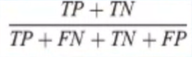
2.   Precision

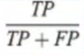
3.   Recall

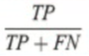
4.   F1-score

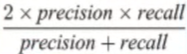

Como el resultado obtenido fue exactamente el mismo para cada métrica, se dejó ejecutado solamente el accuracy. De todos modos, el resto se encuentran en el código para poder ser utilizadas y verificar dado el caso.

In [29]:
def clasificadores(df_x, df_y, test_size_DT, test_size_SVM, test_size_kN, test_size_RF):

  ######## Arboles de decisiones ########

  # Cargamos la data y el target
  xf_DT = df_x
  yf_DT = df_y

  # Estandarizamos
  scaler = StandardScaler()
  scaler.fit(xf_DT)
  xf_DT = scaler.transform(xf_DT)

  # Dividimos los datos en un conjunto de entrenamiento y un conjunto de prueba
  Xf_train_DT, Xf_test_DT, yf_train_DT, yf_test_DT = train_test_split(xf_DT.T, yf_DT.T, test_size = test_size_DT, random_state = 0)

  # Los datos del target son strings
  yf_train_DT = yf_train_DT.astype(str)
  yf_test_DT = yf_test_DT.astype(str)

  # Creación de clasificador con la técnica de árboles de decisiones
  clf_DT = DecisionTreeClassifier(random_state = 0)

  # Entrenamiento del clasificador
  clf_DT.fit(Xf_train_DT, yf_train_DT)

  # Metricas de evaluación
  # Matriz de confusión
  print(f"\033[1mClasificador obtenido con la técnica de árbol de decisión\033[0m")
  disp_DT = ConfusionMatrixDisplay.from_estimator(clf_DT, Xf_test_DT, yf_test_DT, normalize='all', cmap=plt.cm.Blues)
  disp_DT.ax_.set_title("\nMatriz de confusión (árbol de decisión)")
  plt.show()

  # Accuracy
  yf_pred_DT = clf_DT.predict(Xf_test_DT)
  accu_DT = accuracy_score(yf_test_DT, yf_pred_DT)
  print("\nAccuracy score (árbol de decisión):", round(accu_DT,4))

  # # Precision
  # yf_pred_DT = clf_DT.predict(Xf_test_DT)
  # prec_DT = precision_score(yf_test_DT, yf_pred_DT, average = 'micro')
  # print('Precision score (árbol de decisión)', round(prec_DT,4))

  # # Recall
  # yf_pred_DT = clf_DT.predict(Xf_test_DT)
  # recall_DT = recall_score(yf_test_DT, yf_pred_DT, average = 'micro')
  # print('Recall score (árbol de decisión)', round(recall_DT,4))

  # # f1
  # yf_pred_DT = clf_DT.predict(Xf_test_DT)
  # f1_DT = f1_score(yf_test_DT, yf_pred_DT, average = 'micro')
  # print('f1 score (árbol de decisión)', round(f1_DT,4))

  ######## SVM ########

  # Cargamos la data y el target
  xf_SVM = df_x
  yf_SVM = df_y

  # Estandarizamos
  scaler = StandardScaler()
  scaler.fit(xf_SVM)
  xf_SVM = scaler.transform(xf_SVM)

  # Dividimos los datos en un conjunto de entrenamiento y un conjunto de prueba
  Xf_train_SVM, Xf_test_SVM, yf_train_SVM, yf_test_SVM = train_test_split(xf_SVM.T, yf_SVM.T, test_size = test_size_SVM, random_state = 0)

  # Los datos del target son strings
  yf_train_SVM = yf_train_SVM.astype(str)
  yf_test_SVM = yf_test_SVM.astype(str)

  # Creación de clasificador con la técnica de SVM
  clf_SVM = svm.SVC(random_state = 0)

  # Entrenamiento del clasificador
  clf_SVM.fit(Xf_train_SVM, yf_train_SVM.values.ravel())

  # Metricas de evaluación
  # Matriz de confusión
  print(f"\n\033[1mClasificador obtenido con la técnica de support vector machine\033[0m")
  disp_SVM = ConfusionMatrixDisplay.from_estimator(clf_SVM, Xf_test_SVM, yf_test_SVM, normalize='all', cmap=plt.cm.Blues)
  disp_SVM.ax_.set_title("\nMatriz de confusión (SVM)")
  plt.show()

  # Accuracy
  yf_pred_SVM = clf_SVM.predict(Xf_test_SVM)
  accu_SVM = accuracy_score(yf_test_SVM, yf_pred_SVM)
  print("\nAccuracy score (SVM):", round(accu_SVM,4))

  # # Precision
  # yf_pred_SVM = clf_SVM.predict(Xf_test_SVM)
  # prec_SVM = precision_score(yf_test_SVM, yf_pred_SVM, average = 'micro')
  # print('Precision score (SVM)', round(prec_SVM,4))

  # # Recall
  # yf_pred_SVM = clf_SVM.predict(Xf_test_SVM)
  # recall_SVM = recall_score(yf_test_SVM, yf_pred_SVM, average = 'micro')
  # print('Recall score (SVM)', round(recall_SVM,4))

  # # f1
  # yf_pred_SVM = clf_SVM.predict(Xf_test_SVM)
  # f1_SVM = f1_score(yf_test_SVM, yf_pred_SVM, average = 'micro')
  # print('f1 score (SVM)', round(f1_SVM,4))

  ######## k Vecinos ########

  # Cargamos la data y el target
  xf_kN = df_x
  yf_kN = df_y

  # Estandarizamos
  scaler_kN = StandardScaler()
  scaler_kN.fit(xf_kN)
  xf_kN = scaler.transform(xf_kN)

  # Dividimos los datos en un conjunto de entrenamiento y un conjunto de prueba
  Xf_train_kN, Xf_test_kN, yf_train_kN, yf_test_kN = train_test_split(xf_kN.T, yf_kN.T, test_size = test_size_kN, random_state = 0)

  # Los datos del target son strings
  yf_train_kN = yf_train_kN.astype(str)
  yf_test_kN = yf_test_kN.astype(str)

  # Creación de clasificador con la técnica de k Vecinos
  clf_kN = KNeighborsClassifier(n_neighbors = 5)

  # Entrenamiento del clasificador
  clf_kN.fit(Xf_train_kN, yf_train_kN.values.ravel())

  # Metricas de evaluación
  # Matriz de confusión
  print(f"\n\033[1mClasificador obtenido con la técnica de k vecinos más cercanos\033[0m")
  disp_kN = ConfusionMatrixDisplay.from_estimator(clf_kN, Xf_test_kN, yf_test_kN, normalize='all', cmap=plt.cm.Blues)
  disp_kN.ax_.set_title("\nMatriz de confusión (k vecinos)")
  plt.show()

  # Accuracy
  yf_pred_kN = clf_kN.predict(Xf_test_kN)
  accu_kN = accuracy_score(yf_test_kN, yf_pred_kN)
  print("\nAccuracy score (k vecinos):", round(accu_kN,4))

  # # Precision
  # yf_pred_kN = clf_kN.predict(Xf_test_kN)
  # prec_kN = precision_score(yf_test_kN, yf_pred_kN, average = 'micro')
  # print('Precision score (k vecinos)', round(prec_kN,4))

  # # Recall
  # yf_pred_kN = clf_kN.predict(Xf_test_kN)
  # recall_kN = recall_score(yf_test_kN, yf_pred_kN, average = 'micro')
  # print('Recall score (k vecinos)', round(recall_kN,4))

  # # f1
  # yf_pred_kN = clf_kN.predict(Xf_test_kN)
  # f1_kN = recall_score(yf_test_kN, yf_pred_kN, average = 'micro')
  # print('f1 score (k vecinos)', round(f1_kN,4))

  ######## random forest ########

  # Cargamos la data y el target
  xf_RF = df_x
  yf_RF = df_y

  # Estandarizamos
  scaler_RF = StandardScaler()
  scaler_RF.fit(xf_RF)
  xf_RF = scaler.transform(xf_RF)

  # Dividimos los datos en un conjunto de entrenamiento y un conjunto de prueba
  Xf_train_RF, Xf_test_RF, yf_train_RF, yf_test_RF = train_test_split(xf_RF.T, yf_RF.T, test_size = test_size_RF, random_state = 0)

  # Los datos del target son strings
  yf_train_RF = yf_train_RF.astype(str)
  yf_test_RF = yf_test_RF.astype(str)

  # Creación de clasificador con la técnica de random forest
  clf_RF = RandomForestClassifier(n_estimators = 150, max_depth = 5, random_state = 0)

  # Entrenamiento del clasificador
  clf_RF.fit(Xf_train_RF, yf_train_RF.values.ravel())

  # Metricas de evaluación
  # Matriz de confusión
  print(f"\n\033[1mClasificador obtenido con la técnica de random forest\033[0m")
  disp_RF = ConfusionMatrixDisplay.from_estimator(clf_RF, Xf_test_RF, yf_test_RF, normalize='all', cmap=plt.cm.Blues)
  disp_RF.ax_.set_title("\nMatriz de confusión (random forest)")
  plt.show()

  # Accuracy
  yf_pred_RF = clf_RF.predict(Xf_test_RF)
  accu_RF = accuracy_score(yf_test_RF, yf_pred_RF)
  print("\nAccuracy score (random forest):", round(accu_RF,4))

  # # Precision
  # yf_pred_RF = clf_RF.predict(Xf_test_RF)
  # prec_RF = precision_score(yf_test_RF, yf_pred_RF, average = 'micro')
  # print('Precision score (random forest)', round(prec_RF,4))

  # # Recall
  # yf_pred_RF = clf_RF.predict(Xf_test_RF)
  # recall_RF = precision_score(yf_test_RF, yf_pred_RF, average = 'micro')
  # print('Recall score (random forest)', round(recall_RF,4))

  # # f1
  # yf_pred_RF = clf_RF.predict(Xf_test_RF)
  # f1_RF = precision_score(yf_test_RF, yf_pred_RF, average = 'micro')
  # print('f1 score (random forest)', round(f1_RF,4))

  return clf_DT, clf_SVM, clf_kN, clf_RF

A continuación, para cada uno de los DataFrames, se obtienen los 4 clasificadores con su respectiva matriz de confusión y *accuracy score*.

### FFT

Clasificador obtenido con la técnica de árbol de decisión


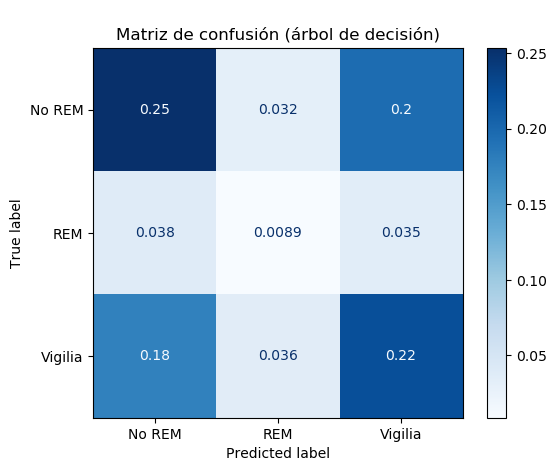


Accuracy score (árbol de decisión): 0.4861

Clasificador obtenido con la técnica de support vector machine


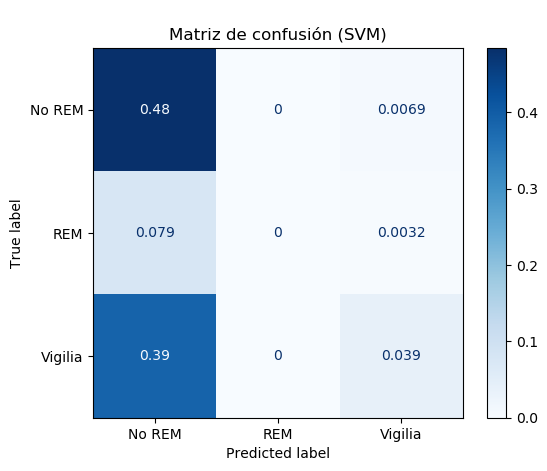


Accuracy score (SVM): 0.5227

Clasificador obtenido con la técnica de k vecinos más cercanos


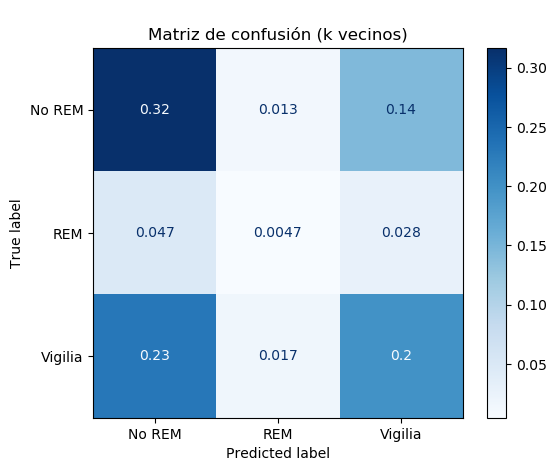


Accuracy score (k vecinos): 0.5206

Clasificador obtenido con la técnica de random forest


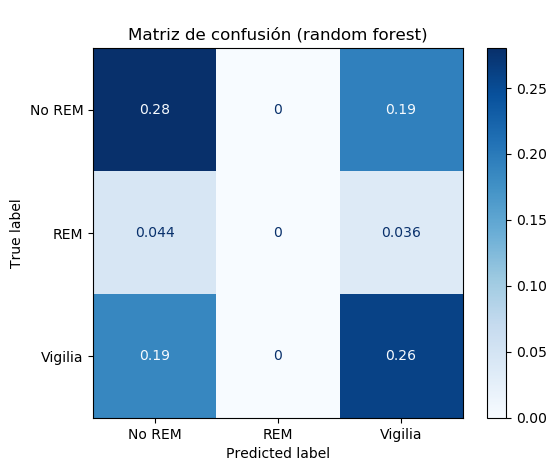


Accuracy score (random forest): 0.5396


In [30]:
df_x_fft = df_fft.T[1:7]
df_y_fft = df_fft.T[-1:]

clf_DT_fft, clf_SVM_fft, clf_kN_fft, clf_RF_fft = clasificadores(df_x_fft, df_y_fft, 0.25, 0.3, 0.2, 0.2)

### Modelo AR

Clasificador obtenido con la técnica de árbol de decisión


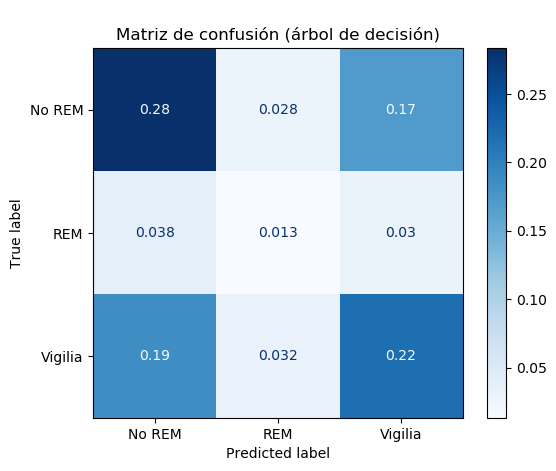


Accuracy score (árbol de decisión): 0.5152

Clasificador obtenido con la técnica de support vector machine


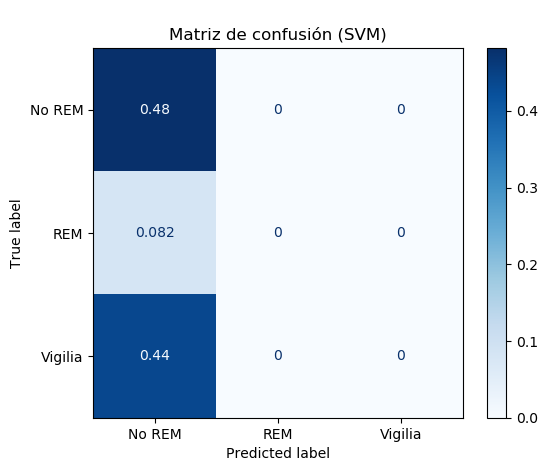


Accuracy score (SVM): 0.4816

Clasificador obtenido con la técnica de k vecinos más cercanos


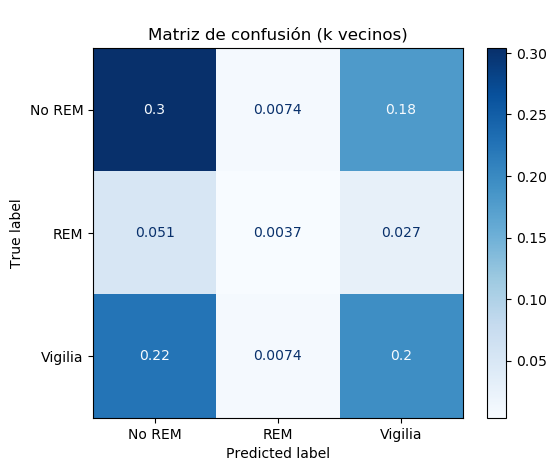


Accuracy score (k vecinos): 0.5032

Clasificador obtenido con la técnica de random forest


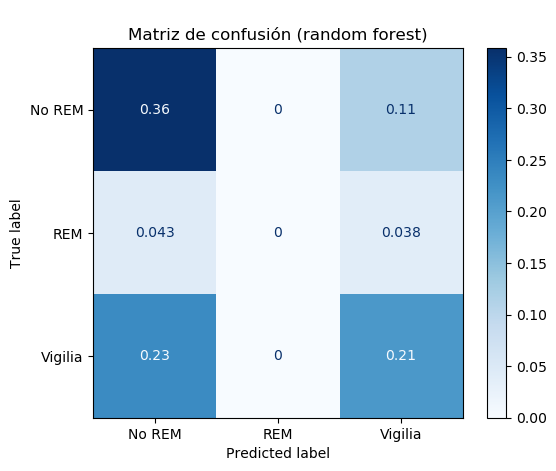


Accuracy score (random forest): 0.5712


In [31]:
df_x_ar = df_ar.T[1:7]
df_y_ar = df_ar.T[-1:]

clf_DT_ar, clf_SVM_ar, clf_kN_ar, clf_RF_ar = clasificadores(df_x_ar, df_y_ar, 0.25, 0.25, 0.3, 0.2)

### Periodograma de Lomb

Clasificador obtenido con la técnica de árbol de decisión


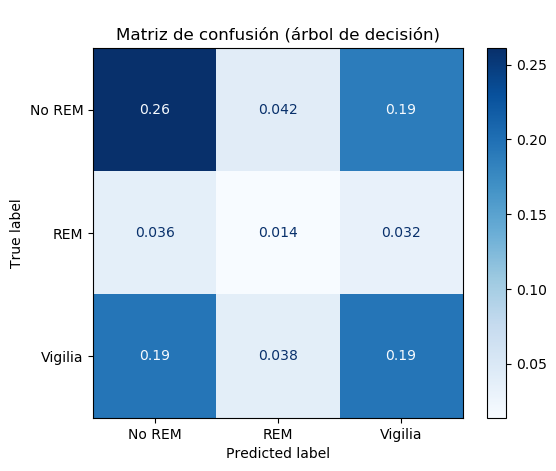


Accuracy score (árbol de decisión): 0.4694

Clasificador obtenido con la técnica de support vector machine


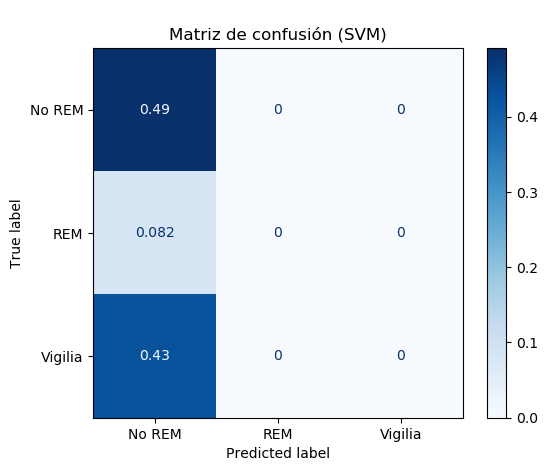


Accuracy score (SVM): 0.491

Clasificador obtenido con la técnica de k vecinos más cercanos


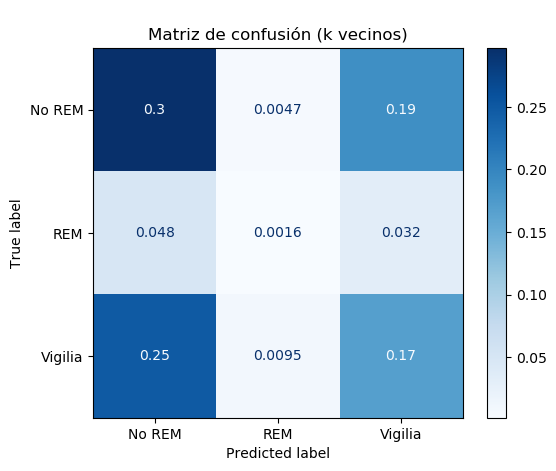


Accuracy score (k vecinos): 0.4668

Clasificador obtenido con la técnica de random forest


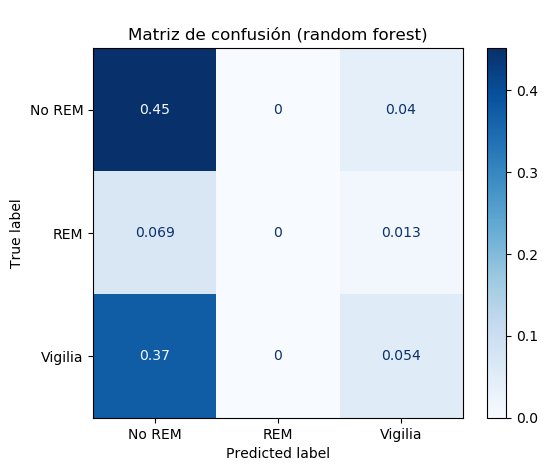


Accuracy score (random forest): 0.5047


In [32]:
df_x_lomb = df_lomb.T[1:7]
df_y_lomb = df_lomb.T[-1:]

clf_DT_lomb, clf_SVM_lomb, clf_kN_lomb, clf_RF_lomb = clasificadores(df_x_lomb, df_y_lomb, 0.3, 0.3, 0.3, 0.3)

#Análisis y conclusiones

En base a los resultados de los clasificadores, podemos decir que el mejor clasificador que hemos encontrado es el obtenido con la técnica de *random forest* y con las características epectrales calculadas con el modelo AR. Este tiene una precisión de 0,57.

A nivel general,observamos que el estado más difícil de clasificar es la etapa REM. Algunos de los clasificadores no pudieron clasificar ningun segmento de prueba en etapa REM. Una posible razón por la que esto sucede es la menor cantidad de segmentos de etapa REM que se tiene en el conjunto de datos, en comparación con las otras etapas de sueño. Conociendo la duración de las señales, es posible ver que estas duran entre 2 y 6 horas y media, por lo que es posible creer que los pacientes solo pudieron completar pocas fases REM, y entonces la cantidad de segmentos en fase REM es baja. Además, esta etapa ya de por sí es más corta que la etapa no REM. Por lo tanto, es posible decir que para mejorar el clasificador se necesitarían utilizar más datos correspondientes al sueño REM.

Con respecto al algoritmo de densidad espectral, al utilizar las características calculadas con el periodograma de Lomb se obtienen clasificadores con las menores precisiones. Con modelo AR, los clasificadores de árboles de decisiones y *random forest* tienen mayor precisión que al utilizar las características obtenidas con FFT. Mientras que con FFT los clasificadores de SVM y k vecinos más cercanos tienen mayor precisión que al utilizar las características obtenidas con modelo AR.